In the below project I will create a RNN model that determines if a given example has a given defect.

Each example is a combination of 3 sine waves with some noise. Each of the 5 defects possible in data is introduced in createRow function. The defects can exist together.

After the model is trained an effort to explain it was made:
 - There is a method that points to the channel where the defect is coming from (we assume this has to be checked per example and that a defect is not assigned to a specific channel)
 - Another method shows where the defect has occured in time

# Imports and data creation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

In [3]:
n = 50000

In [4]:
def createRow(n, classes):
    base = np.sin(np.linspace((np.random.rand(3)),(np.random.rand(3) + np.array([10,15,7])),n))
    if classes[0] > 0:
        base[np.random.randint(0,n), 0] += 2
    if classes[1] > 0:
        base[np.random.randint(0,n), 1] -= 2
    if classes[2] > 0:
        x = np.random.randint(0,n-5)
        base[x:x+4,2] = 0
    if classes[3] > 0:
        x = np.random.randint(0,n-10)
        base[x:x+8,1] += 1.5
    if classes[4] > 0:
        x = np.random.randint(0,n-7)
        base[x:x+6,0] += 1.5
        base[x:x+6,2] -= 1.5
    base += np.random.rand(*base.shape)*.2
    return base

In [5]:
xl, yl = [], []
for _ in range(n):
    cl = np.random.rand(5)<.25
    xl.append(createRow(np.random.randint(40,60), cl))
    yl.append(cl)


[False False False False  True]


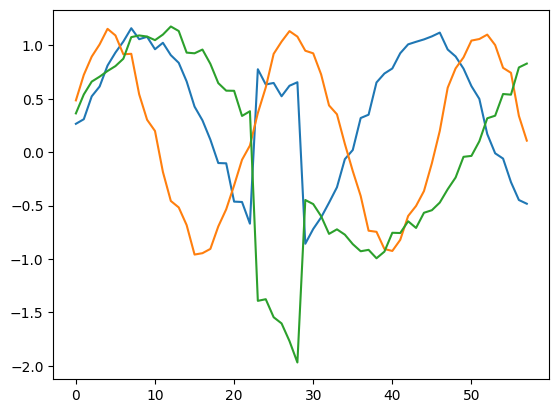

[False False False  True  True]


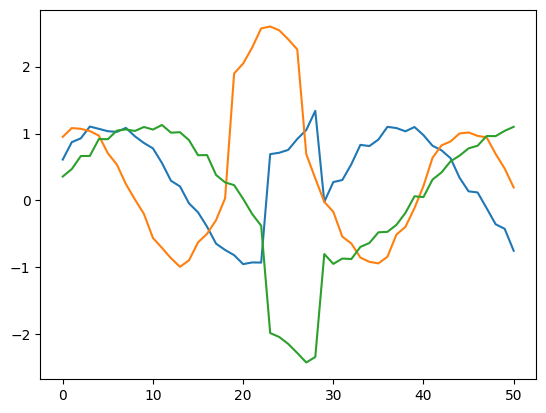

[False False False False False]


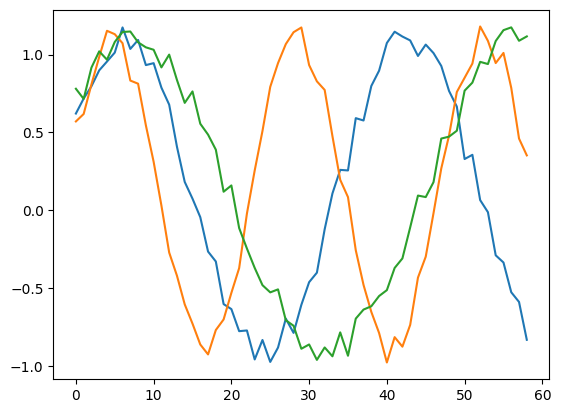

[ True False False False  True]


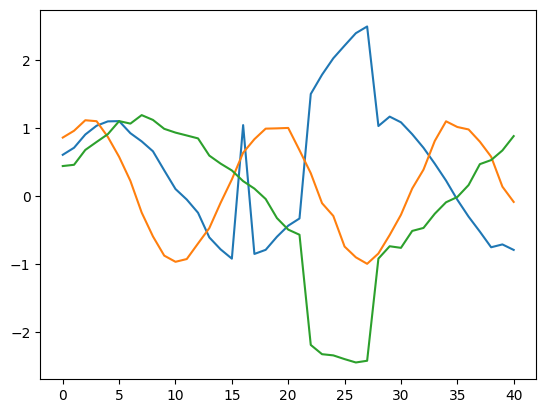

[False  True False False False]


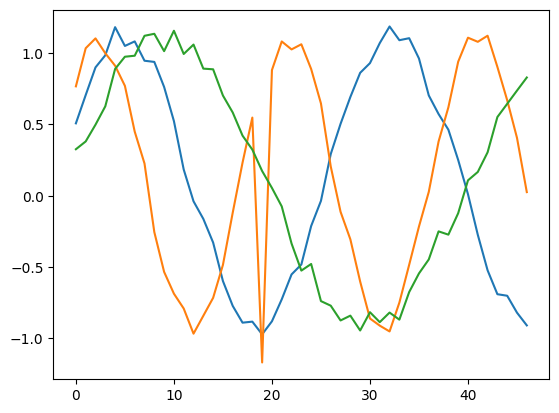

In [6]:
for i in range(5):
    plt.plot(xl[i])
    print(yl[i])
    plt.show()

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape, GlobalMaxPool1D, Lambda, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
import random

from sklearn.metrics import precision_score, recall_score, accuracy_score

%matplotlib inline

2025-01-19 14:23:26.015470: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-19 14:23:26.291326: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-19 14:23:26.350431: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-19 14:23:26.618893: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-19 14:23:28.859452: W tensorflow/compiler/tf2

In [8]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, enable=True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1737293010.077153   13213 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737293010.438372   13213 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737293010.438643   13213 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [ ]:
# The distribution of length is uniform and each length has at least 2400 examples, so there is no problem if I train the model on one lenght at a time
len_count = {}
for x in xl:
    length = x.shape[0]
    len_count[length] = len_count.get(length,0) + 1

len_count

{58: 2497,
 51: 2419,
 59: 2514,
 41: 2468,
 47: 2524,
 57: 2542,
 50: 2468,
 52: 2498,
 54: 2475,
 42: 2499,
 46: 2498,
 44: 2516,
 49: 2482,
 40: 2446,
 53: 2575,
 48: 2509,
 45: 2463,
 43: 2623,
 55: 2476,
 56: 2508}

# Processing the data for the model (create separete arrays for different length series and train, validation, test split)

In [12]:
def get_data_of_length(xl, yl):
    """
    Creates dictionaries that store data for each length under the corresponding key
    """
    xl_dict = {}
    yl_dict = {}

    for i in range(40,60):
        xl_dict[i] = []
        yl_dict[i] = []
        
    for i in range(len(xl)):
        length = len(xl[i])

        xl_dict[length].append(xl[i])
        yl_dict[length].append(yl[i])

    return xl_dict, yl_dict

In [13]:
xl_dict, yl_dict = get_data_of_length(xl, yl)

In [14]:

def get_split_from_dict(xl_dict: dict, yl_dict: dict,train_split = 0.8 ,val_split = 0.1, test_split = 0.1):
    """
    Splits data in dictionaries into train, validation and test sets
    """
    xl_train_dict = {}
    yl_train_dict = {}
    xl_val_dict = {}
    yl_val_dict = {}
    xl_test_dict = {}
    yl_test_dict = {}
        
    for length in xl_dict.keys():
        size = len(xl_dict[length])

        train_size = int(train_split * size)
        val_size = int(val_split * size)
        test_size = int(test_split * size)

        xl_train_dict[length] = np.array(xl_dict[length][:train_size])
        yl_train_dict[length] = np.array(yl_dict[length][:train_size])

        xl_val_dict[length] = np.array(xl_dict[length][train_size: train_size + val_size])
        yl_val_dict[length] = np.array(yl_dict[length][train_size: train_size + val_size])

        xl_test_dict[length] = np.array(xl_dict[length][train_size + val_size:])
        yl_test_dict[length] = np.array(yl_dict[length][train_size + val_size:])

    return xl_train_dict, yl_train_dict, xl_val_dict, yl_val_dict, xl_test_dict, yl_test_dict

In [15]:
xl_train_dict, yl_train_dict, xl_val_dict, yl_val_dict, xl_test_dict, yl_test_dict = get_split_from_dict(xl_dict, yl_dict)

In [16]:
def train_all_lenghts(model, repetitions = 1, epochs = 10, batch_size = 450):
    """
    Is responsible for training of the model by using examples of same length in the given batch. During each repetition the lengths are shuffled.
    """
    early = EarlyStopping(patience=7, restore_best_weights=True) # it is unused because it was stopping the training way too early and letting it run always resulted in improvement even when it was slow
    for _ in range(repetitions):
        lst = list(range(40,60))
        random.shuffle(lst)

        for input_size in lst:
            model.fit(xl_train_dict[input_size],yl_train_dict[input_size], validation_data=[xl_val_dict[input_size],yl_val_dict[input_size]], batch_size=batch_size, epochs=epochs, callbacks=[])

# Create and train the model

In [ ]:
# Craetion of model
model = Sequential()
model.add(LSTM(64, input_shape=(None,3), return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(16, return_sequences=True))
model.add(LSTM(5, return_sequences=False, activation="sigmoid"))
model.compile(loss='mse')
model.summary()

/home/deniz/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, None, 64)       │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, None, 32)       │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, None, 16)       │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 5)              │           440 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,400 (130.47 KB)

 Trainable params: 33,400 (130.47 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Load weights trained previously on the same model to save time
model.load_weights('model.weights.h5')

In [164]:
train_all_lenghts(model, repetitions=10, batch_size=450, epochs=3)
train_all_lenghts(model, repetitions=2, batch_size=450, epochs=1)

Epoch 1/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - loss: 0.0748 - val_loss: 0.0702
Epoch 2/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0719 - val_loss: 0.0692
Epoch 3/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - loss: 0.0709 - val_loss: 0.0684
Epoch 1/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - loss: 0.0736 - val_loss: 0.0788
Epoch 2/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - loss: 0.0763 - val_loss: 0.0719
Epoch 3/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - loss: 0.0755 - val_loss: 0.1016
Epoch 1/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - loss: 0.0937 - val_loss: 0.0723
Epoch 2/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - loss: 0.0753 - val_loss: 0.0702
Epoch 3/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - loss: 0.0727 - val_loss: 0.0661
Epoch 1/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - loss: 0.0711 - val_loss: 0.0741
Epoch 2/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - loss: 0.0724 - val_loss: 0.0714
Epoch 3/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - loss: 0.0725 - val_loss: 0.0780
Epoc

# Test the models performace

In [201]:
y_true = None
y_pred = None

for length in range(40,60):
    predictions = model.predict(xl_test_dict[length])
    predictions = predictions>0.5

    if y_true is None and y_pred is None: 
        y_pred = predictions
        y_true = yl_test_dict[length]
    
    else:
        y_true = np.concatenate((y_true, yl_test_dict[length]))
        y_pred = np.concatenate((y_pred, predictions))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [160]:
for i in range(5):
    acc = accuracy_score(y_true[:, i], y_pred[:, i])
    precision = precision_score(y_true[:, i], y_pred[:, i])
    recall = recall_score(y_true[:, i], y_pred[:, i])
    print(f"Defect {i}: Accuracy={acc:.5f}, Precision={precision:.5f}, Recall={recall:.5f}")

Defect 0: Accuracy=0.99861, Precision=0.99529, Recall=0.99921
Defect 1: Accuracy=0.99880, Precision=0.99600, Recall=0.99920
Defect 2: Accuracy=0.99024, Precision=0.99916, Recall=0.96107
Defect 3: Accuracy=1.00000, Precision=1.00000, Recall=1.00000
Defect 4: Accuracy=1.00000, Precision=1.00000, Recall=1.00000


In [202]:
all_correct_true = np.all(y_true == y_pred, axis=1)
# print(np.unique(all_correct_true, return_counts=True))

accuracy = np.unique(all_correct_true, return_counts=True)[1][1]/len(all_correct_true)

print(f"Percentage of examples where ALL defects were correctly classified: {accuracy:.5f}") # Out of tested 5020 examples only 61 had any sort of error :)

Percentage of examples where ALL defects were correctly classified: 0.98785


# Finding root cause

## Inspecting the current model

In [204]:
# Create a version of the model that returns all outputs instead of the final one so we can plot it
model = Sequential()
model.add(LSTM(64, input_shape=(None,3), return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(16, return_sequences=True))
model.add(LSTM(5, return_sequences=True, activation="sigmoid"))
model.compile(loss='mse')
model.summary()

/home/deniz/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, None, 64)       │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, None, 32)       │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, None, 16)       │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, None, 5)        │           440 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,400 (130.47 KB)

 Trainable params: 33,400 (130.47 KB)

 Non-trainable params: 0 (0.00 B)

In [208]:
model.load_weights('model.weights.h5') #Load the weights from the previous version of the model

The first graph is the input, some example series. The second graph is the activation of our model for each step. This pattern will be used several times for inspection later on.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
[False False False  True False]
[False False False  True False]


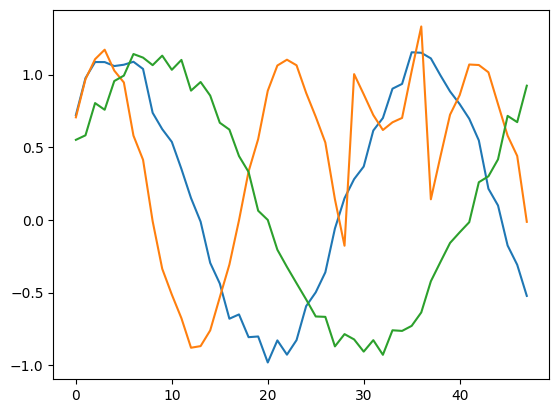

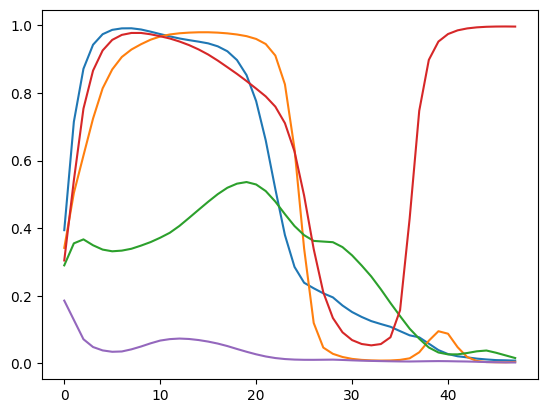

In [207]:
length = np.random.randint(40,60)
i = np.random.randint(0,200)

single_sample = np.expand_dims(xl_test_dict[length][i], axis=0) 
output = model.predict(single_sample)[0]

print(yl_test_dict[length][i])
print(output[-1] > 0.5)

plt.plot(xl_test_dict[length][i])
plt.show()

plt.plot(output)
plt.show()

This model is quiete accurate, but behaves in an unnatural way in the middle and at the beginning of the series, since we only hold it accountable for the final output. This makes explaination of the prediction quite difficult

## MAX value model

If we take the maximum of the models output for each defect we will create a model that needs to have a False output if there is no defect even if it is in the middle of the series, resulting in a model that returns True only when a defect is detected and the activation is very close to it in time. This way we will have more information about the defect from inspecting the activation plot

In [209]:
model = Sequential()
model.add(LSTM(64, input_shape=(None, 3), return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(16, return_sequences=True))
model.add(LSTM(5, return_sequences=True, activation='sigmoid'))

model.add(Lambda(lambda x: K.max(x, axis=1)))  # Compute the max across timesteps for each feature

model.summary()
model.compile(loss='mse')

/home/deniz/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, None, 64)       │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, None, 32)       │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, None, 16)       │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, None, 5)        │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,400 (130.47 KB)

 Trainable params: 33,400 (130.47 KB)

 Non-trainable params: 0 (0.00 B)

Train the model

In [210]:
model.load_weights('modelMAX.weights.h5') # Load previously trained weights on the same model to save time

/home/deniz/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [204]:
train_all_lenghts(model, batch_size=450, epochs = 10, repetitions=10)
train_all_lenghts(model, batch_size=450, epochs = 3, repetitions=10)
train_all_lenghts(model, batch_size=450, epochs = 1, repetitions=2)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 376ms/step - loss: 0.2021 - val_loss: 0.1974
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - loss: 0.1963 - val_loss: 0.1949
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.1937 - val_loss: 0.1933
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - loss: 0.1923 - val_loss: 0.1920
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - loss: 0.1903 - val_loss: 0.1908
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - loss: 0.1894 - val_loss: 0.1895
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - loss: 0.1881 - val_loss: 0.1884
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - loss: 0.1871 - val_loss: 0.1869
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - loss: 0.1856 - val_loss: 0.1854
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - loss: 0.1841 - val_loss: 0.1835
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 418ms/step - loss: 0.1850 - val_loss: 0.1810
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - loss: 0.1829 - val_loss

## Test the new models performance

In [215]:
y_true = None
y_pred = None

for length in range(40,60):
    predictions = model.predict(xl_test_dict[length])
    predictions = predictions>0.5

    if y_true is None and y_pred is None: 
        y_pred = predictions
        y_true = yl_test_dict[length]
    
    else:
        y_true = np.concatenate((y_true, yl_test_dict[length]))
        y_pred = np.concatenate((y_pred, predictions))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [216]:
for i in range(5):
    acc = accuracy_score(y_true[:, i], y_pred[:, i])
    precision = precision_score(y_true[:, i], y_pred[:, i])
    recall = recall_score(y_true[:, i], y_pred[:, i])
    print(f"Defect {i}: Accuracy={acc:.5f}, Precision={precision:.5f}, Recall={recall:.5f}")

Defect 0: Accuracy=0.99861, Precision=1.00000, Recall=0.99448
Defect 1: Accuracy=0.99841, Precision=0.99839, Recall=0.99518
Defect 2: Accuracy=0.98526, Precision=0.99828, Recall=0.94161
Defect 3: Accuracy=1.00000, Precision=1.00000, Recall=1.00000
Defect 4: Accuracy=1.00000, Precision=1.00000, Recall=1.00000


In [219]:
all_correct_true = np.all(y_true == y_pred, axis=1)
# print(np.unique(all_correct_true, return_counts=True))

accuracy = np.unique(all_correct_true, return_counts=True)[1][1]/len(all_correct_true)

print(f"Percentage of examples where ALL defects were correctly classified: {accuracy:.5f}") # Out of tested 5020 examples only 89 had any sort of error :)

Percentage of examples where ALL defects were correctly classified: 0.98227


The results for this model are very good, but slightly worse to the previous model. It might be because it was trained for a shorter amount of time.

## Inspect MAX model

In [9]:
# Create a variant of this model that returns the entire output instead of just the max of it for plotting purposes
model = Sequential()
model.add(LSTM(64, input_shape=(None, 3), return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(16, return_sequences=True))
model.add(LSTM(5, return_sequences=True, activation='sigmoid'))


# Print the model summary
model.summary()

# Compile the model
model.compile(loss='mse')

I0000 00:00:1737293026.701937   13213 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737293026.703026   13213 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737293026.703810   13213 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737293026.844416   13213 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, None, 64)       │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, None, 32)       │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, None, 16)       │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, None, 5)        │           440 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,400 (130.47 KB)

 Trainable params: 33,400 (130.47 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.load_weights('modelMAX.weights.h5') # Load previous models weights

/home/deniz/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[False  True False False  True] prediction
[False  True False False  True] true


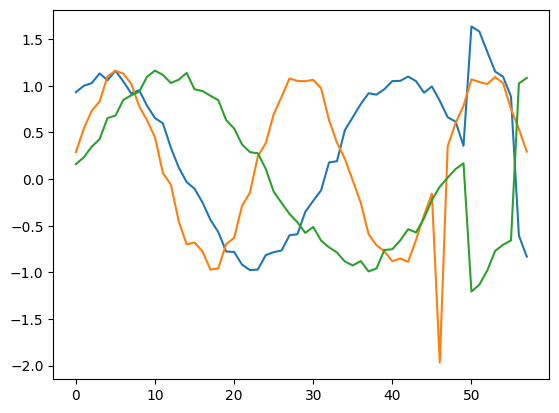

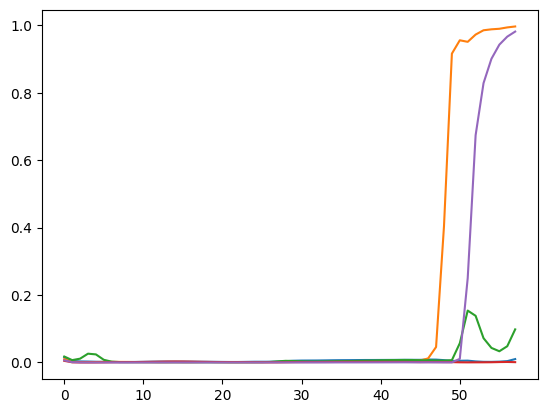

In [25]:
length = np.random.randint(40,60)
i = np.random.randint(0,200)

single_sample = np.expand_dims(xl_test_dict[length][i], axis=0) 
output = model.predict(single_sample)[0]

print(np.max(output, axis=0)> 0.5, 'prediction')
print(yl_test_dict[length][i], 'true')

plt.plot(xl_test_dict[length][i])
plt.show()

plt.plot(output)
plt.show()

There is no premature activation on this model. The activation only happens after the defect has taken place. SUCCESS!

## Finding the responsible channel

Here we create a function that makes a healthy series (no defects) of a given length. We will replace a channel from some series for which we found a defect and will see how the output of our model changes, thus finding the culprit.

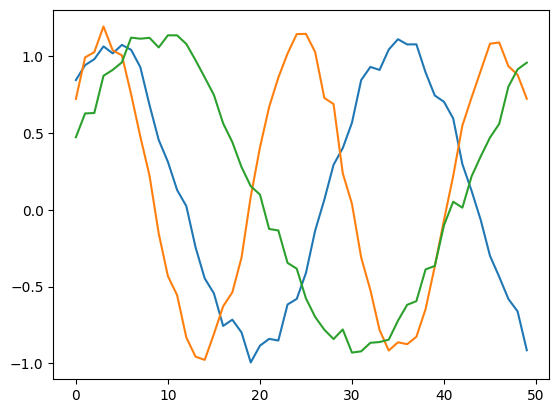

In [37]:
def create_healthy_series(length:int):
        base = np.sin(np.linspace((np.random.rand(3)),(np.random.rand(3) + np.array([10,15,7])),length))
        base += np.random.rand(*base.shape)*.2
        return base

plt.plot(create_healthy_series(50))
plt.show()

In the block below an example series has all of its channels replaced one by one. If a defect that has been detected in the original series is not detected anymore after changing a channel to its healthy counterpart, then the defect was in this channel. This process is done per instance

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[False False  True  True False] prediction
[False False  True  True False] true


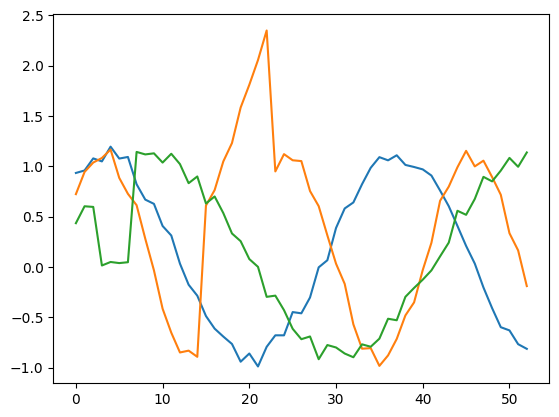

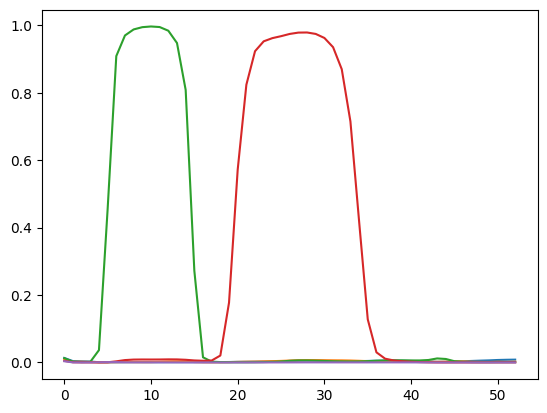

result when replacing channel 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[False False  True  True False] prediction after replacing channel 0


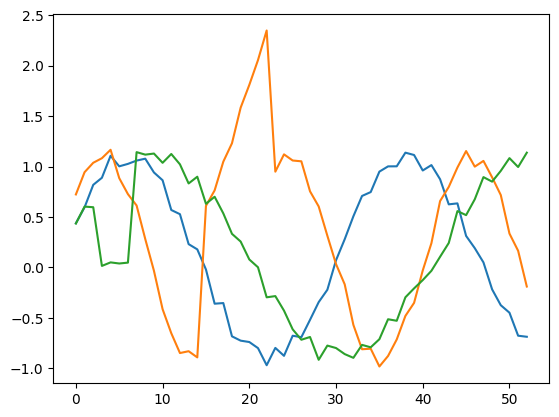

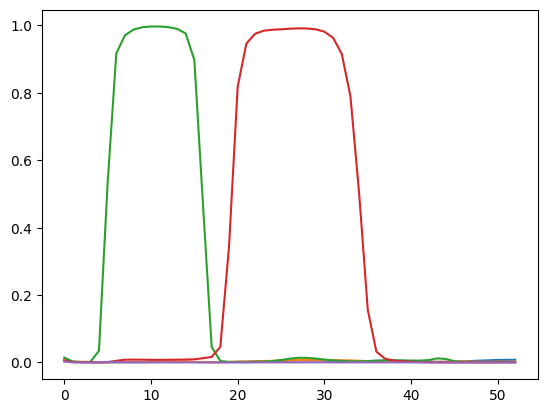

result when replacing channel 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[False False  True False False] prediction after replacing channel 1


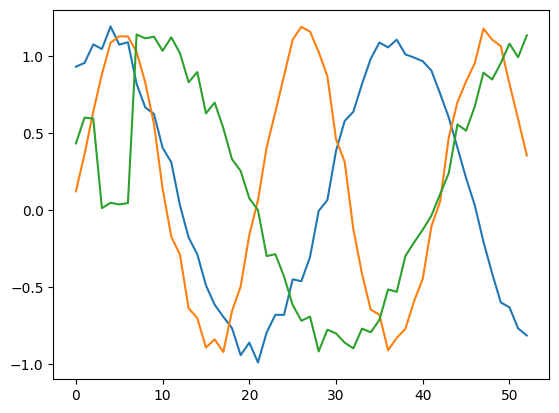

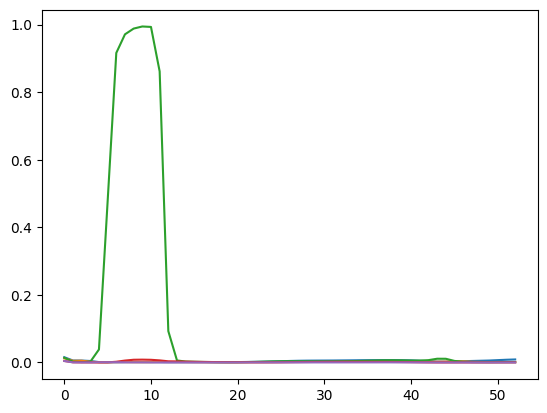

result when replacing channel 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[False False False  True False] prediction after replacing channel 2


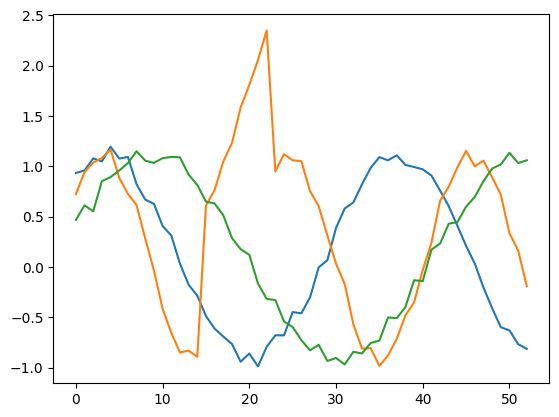

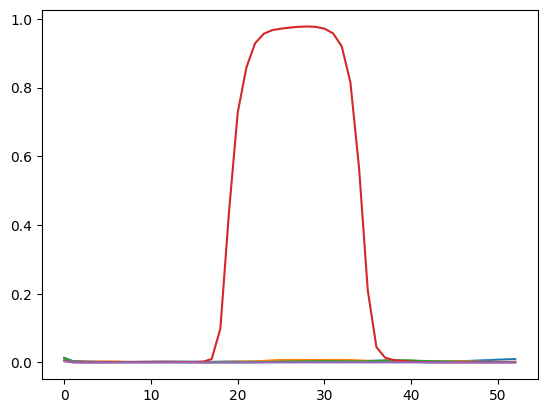

Channel 2 is responsible for defect 2
Channel 1 is responsible for defect 3


In [227]:
length = np.random.randint(40,60)
i = np.random.randint(0,200)

original_input = xl_test_dict[length][i]

def replace_channels(original_input, original_output, draw:bool = True):
    single_sample = np.expand_dims(original_input, axis=0) 
    output = model.predict(single_sample)[0]

    print(np.max(output, axis=0)> 0.5, 'prediction')
    print(original_output, 'true')

    if draw:
        plt.plot(original_input)
        plt.show()

        plt.plot(output)
        plt.show()

    healthy = create_healthy_series(len(original_input))

    print("result when replacing channel 0")

    input0 = original_input.copy()
    input0[:,0] = healthy[:,0]

    single_sample = np.expand_dims(input0, axis=0) 
    output0 = model.predict(single_sample)[0]

    print(np.max(output0, axis=0)> 0.5, 'prediction after replacing channel 0')

    if draw:
        plt.plot(input0)
        plt.show()

        plt.plot(output0)
        plt.show()

    print("result when replacing channel 1")

    input1 = original_input.copy()
    input1[:,1] = healthy[:,1]

    single_sample = np.expand_dims(input1, axis=0) 
    output1 = model.predict(single_sample)[0]

    print(np.max(output1, axis=0)> 0.5, 'prediction after replacing channel 1')

    if draw:
        plt.plot(input1)
        plt.show()

        plt.plot(output1)
        plt.show()

    print("result when replacing channel 2")

    input2 = original_input.copy()
    input2[:,2] = healthy[:,2]

    single_sample = np.expand_dims(input2, axis=0) 
    output2 = model.predict(single_sample)[0]

    print(np.max(output2, axis=0)> 0.5, 'prediction after replacing channel 2')

    if draw:
        plt.plot(input2)
        plt.show()

        plt.plot(output2)
        plt.show()

    for i, defect in enumerate(original_output):
        if defect == True:
            if (np.max(output0, axis=0)> 0.5)[i] == False:
                print(f'Channel 0 is responsible for defect {i}')
            if (np.max(output1, axis=0)> 0.5)[i] == False:
                print(f'Channel 1 is responsible for defect {i}')
            if (np.max(output2, axis=0)> 0.5)[i] == False:
                print(f'Channel 2 is responsible for defect {i}')


replace_channels(original_input, yl_test_dict[length][i], draw=True)

In [228]:
defects = [True, False, False, False, False]
replace_channels(createRow(50, defects), defects, draw=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[ True False False False False] prediction
[True, False, False, False, False] true
result when replacing channel 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[False False False False False] prediction after replacing channel 0
result when replacing channel 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[ True False False False False] prediction after replacing channel 1
result when replacing channel 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[ True False False False False] prediction after replacing channel 2
Channel 0 is responsible for defect 0


In [229]:
defects = [False, True, False, False, False]
replace_channels(createRow(50, defects), defects, draw=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[False  True False False False] prediction
[False, True, False, False, False] true
result when replacing channel 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[False  True False False False] prediction after replacing channel 0
result when replacing channel 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[False False False False False] prediction after replacing channel 1
result when replacing channel 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[False  True False False False] prediction after replacing channel 2
Channel 1 is responsible for defect 1


In [230]:
defects = [False, False, True, False, False]
replace_channels(createRow(50, defects), defects, draw=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[False False  True False False] prediction
[False, False, True, False, False] true
result when replacing channel 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[False False  True False False] prediction after replacing channel 0
result when replacing channel 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[False False  True False False] prediction after replacing channel 1
result when replacing channel 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[False False False False False] prediction after replacing channel 2
Channel 2 is responsible for defect 2


In [231]:
defects = [False, False, False, True, False]
replace_channels(createRow(50, defects), defects, draw=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[False False False  True False] prediction
[False, False, False, True, False] true
result when replacing channel 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[False False False  True False] prediction after replacing channel 0
result when replacing channel 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[False False False False False] prediction after replacing channel 1
result when replacing channel 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[False False False  True False] prediction after replacing channel 2
Channel 1 is responsible for defect 3


In [232]:
defects = [False, False, False, False, True]
replace_channels(createRow(50, defects), defects, draw=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[False False False False  True] prediction
[False, False, False, False, True] true
result when replacing channel 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[False False False False False] prediction after replacing channel 0
result when replacing channel 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[False False False False  True] prediction after replacing channel 1
result when replacing channel 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[ True False  True False False] prediction after replacing channel 2
Channel 0 is responsible for defect 4
Channel 2 is responsible for defect 4


In [ ]:
defects = [False, False, False, False, True] # This method sometimes says that only Channel 2 is responsible for defect 4, while in reality it is 0 and 2. It is because, 0's rise without 2's descent looks like defect 0 sometimes
replace_channels(createRow(50, defects), defects, draw=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
[False False False False  True] prediction
[False, False, False, False, True] true
result when replacing channel 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[False False False False  True] prediction after replacing channel 0
result when replacing channel 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
[False False False False  True] prediction after replacing channel 1
result when replacing channel 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
[ True False  True False False] prediction after replacing channel 2
Channel 2 is responsible for defect 4


This method of finding the responsible channel is very accurate for all defects except the last defect.

## Looking at the output activation to get the position of the defect

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
[False  True False  True  True] prediction
[False  True False  True  True] true


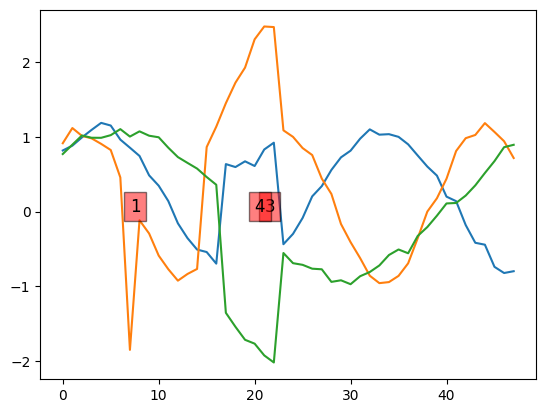

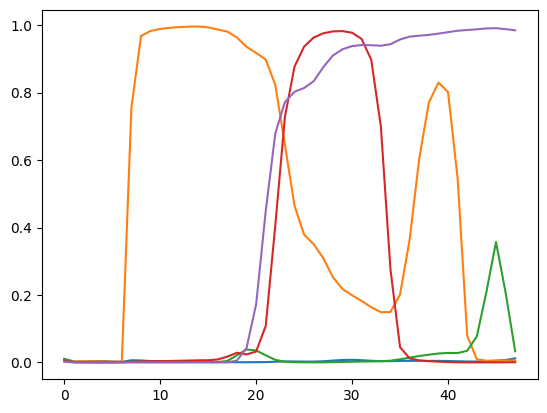

In [264]:
length = np.random.randint(40,60)
i = np.random.randint(0,200)

single_sample = np.expand_dims(xl_test_dict[length][i], axis=0) 
output = model.predict(single_sample)[0]

print(np.max(output, axis=0)> 0.5, 'prediction')
print(yl_test_dict[length][i], 'true')

for j, defect in enumerate(np.max(output, axis=0)> 0.5):
    if defect:
        defect_output = output[:,j]
        index = (defect_output > 0.1).argmax() if np.any(defect_output > 0.1) else None
        plt.text(index, 0, f'{j}', fontsize = 12, 
         bbox = dict(facecolor = 'red', alpha = 0.5))

plt.plot(xl_test_dict[length][i])
plt.show()

plt.plot(output)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
[ True  True False False False] prediction
[ True  True False False False] true


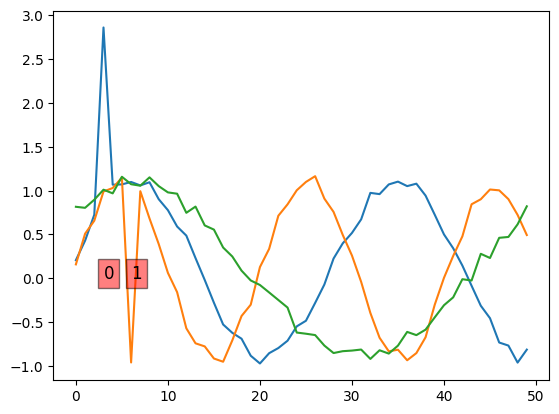

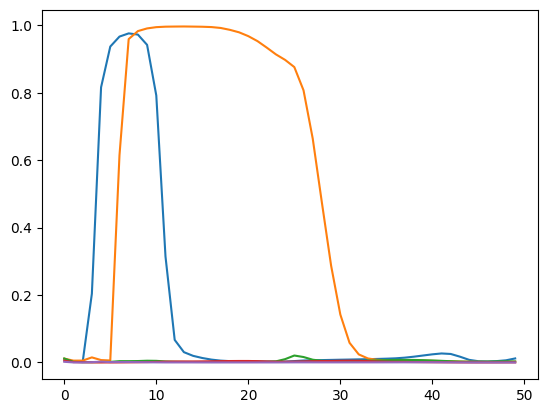

In [251]:
defects = np.array([True, True, False, False, False])
input = createRow(50, defects)

single_sample = np.expand_dims(input, axis=0) 
output = model.predict(single_sample)[0]

print(np.max(output, axis=0)> 0.5, 'prediction')
print(defects, 'true')

for j, defect in enumerate(np.max(output, axis=0)> 0.5):
    if defect:
        defect_output = output[:,j]
        index = (defect_output > 0.1).argmax() if np.any(defect_output > 0.1) else None
        plt.text(index, 0, f'{j}', fontsize = 12, 
         bbox = dict(facecolor = 'red', alpha = 0.5))

plt.plot(input)
plt.show()

plt.plot(output)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
[False False False  True  True] prediction
[False False False  True  True] true


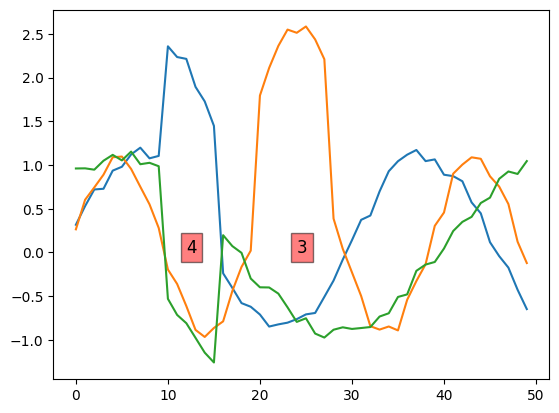

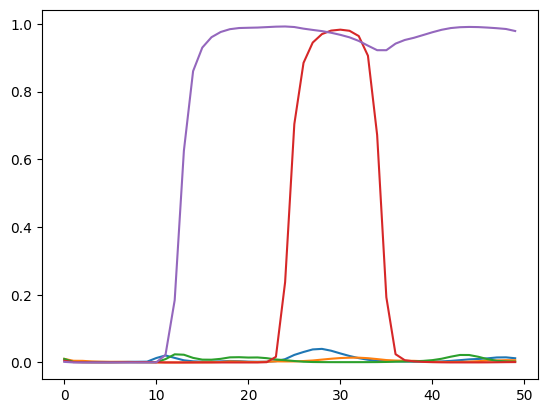

In [266]:
defects = np.array([False, False, False, True, True])
input = createRow(50, defects)

single_sample = np.expand_dims(input, axis=0) 
output = model.predict(single_sample)[0]

print(np.max(output, axis=0)> 0.5, 'prediction')
print(defects, 'true')

for j, defect in enumerate(np.max(output, axis=0)> 0.5):
    if defect:
        defect_output = output[:,j]
        index = (defect_output > 0.1).argmax() if np.any(defect_output > 0.1) else None
        plt.text(index, 0, f'{j}', fontsize = 12, 
         bbox = dict(facecolor = 'red', alpha = 0.5))

plt.plot(input)
plt.show()

plt.plot(output)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
[ True  True False False False] prediction
[True, True, False, False, False] true


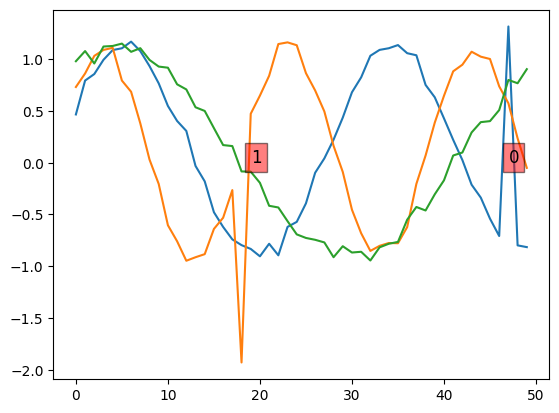

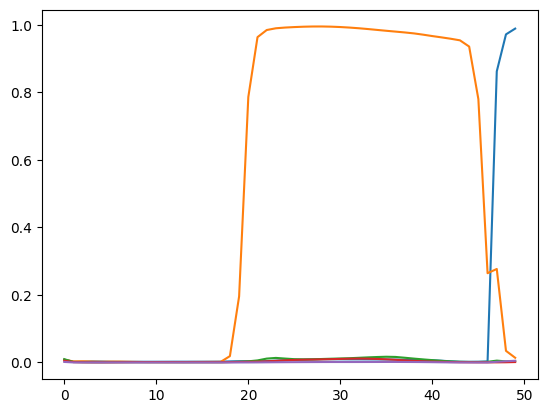

In [ ]:
defects = [True]*2 + [False]*3
input = createRow(50, defects)

single_sample = np.expand_dims(input, axis=0) 
output = model.predict(single_sample)[0]

print(np.max(output, axis=0)> 0.5, 'prediction')
print(defects, 'true')

for j, defect in enumerate(np.max(output, axis=0)> 0.5):
    if defect:
        defect_output = output[:,j]
        index = (defect_output > 0.1).argmax() if np.any(defect_output > 0.1) else None
        plt.text(index, 0, f'{j}', fontsize = 12, 
         bbox = dict(facecolor = 'red', alpha = 0.5))

plt.plot(input)
plt.show()

plt.plot(output)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
[False False  True False False] prediction
[False False  True False False] true


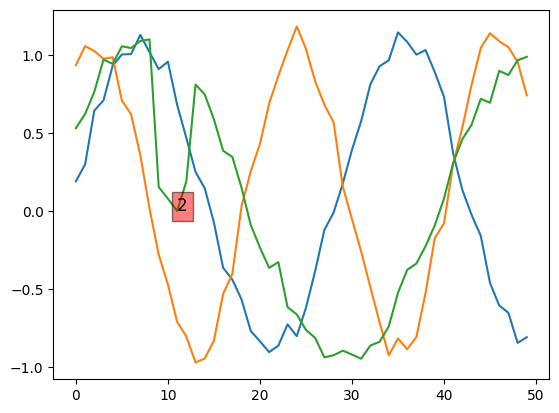

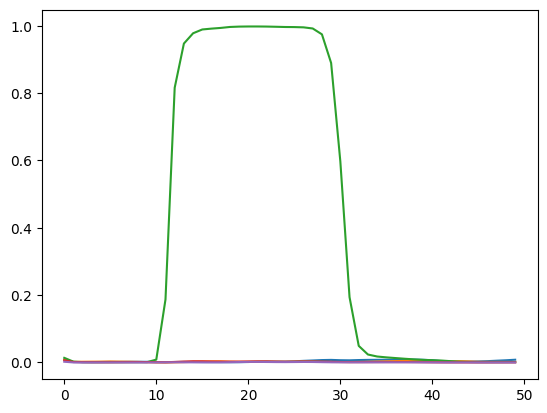

In [275]:
defects = np.array([False]*2 +[True]+ [False]*2)
input = createRow(50, defects)

single_sample = np.expand_dims(input, axis=0) 
output = model.predict(single_sample)[0]

print(np.max(output, axis=0)> 0.5, 'prediction')
print(defects, 'true')

for j, defect in enumerate(np.max(output, axis=0)> 0.5):
    if defect:
        defect_output = output[:,j]
        index = (defect_output > 0.1).argmax() if np.any(defect_output > 0.1) else None
        plt.text(index, 0, f'{j}', fontsize = 12, 
         bbox = dict(facecolor = 'red', alpha = 0.5))

plt.plot(input)
plt.show()

plt.plot(output)
plt.show()

This method is accurate, but it fails to show the areas of defects. Only the point of detection.

## Using a sliding window to find an interval of defect

In [291]:
defects = np.array([False]*2 +[True]+ [False]*2)
input = createRow(50, defects)

single_sample = np.expand_dims(input, axis=0) 
output = model.predict(single_sample)[0]

window_size = 15
window_offset = 5

for i in range((length-window_offset)//window_offset):
    window = single_sample[:,i*window_offset:i*window_offset+window_size,:]
    print('steps:', i*window_offset,i*window_offset+window_size)
    output = model.predict(window)[0]
    print(np.max(output, axis=0)> 0.5)
    # plt.plot(output)
    # plt.show() 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
steps: 0 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[False False False False False]
steps: 5 20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[False False False False False]
steps: 10 25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[False  True  True False False]
steps: 15 30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[False  True  True False False]
steps: 20 35
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[False False  True False False]
steps: 25 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
[False False  True False False]
steps: 30 45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[False  True  True False False]
steps: 35 50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[False  True  True False False]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
0 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[False False False False False]


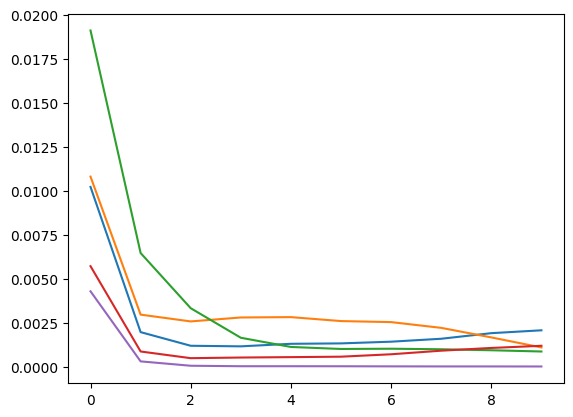

6 16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[False False False False False]


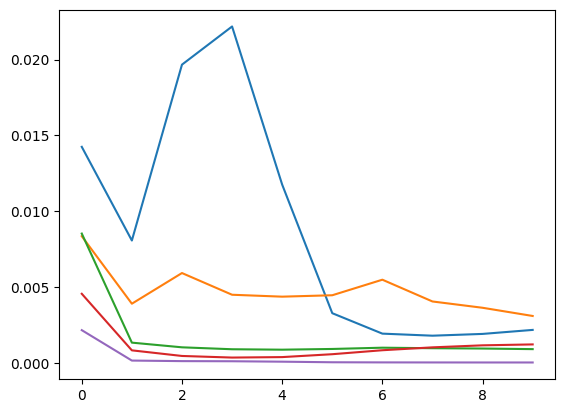

12 22
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[False  True False False False]


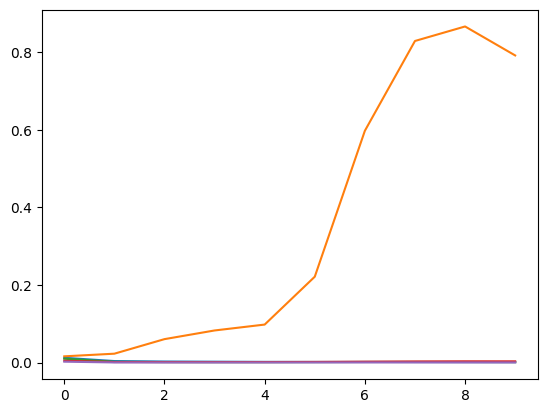

18 28
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[False  True  True False False]


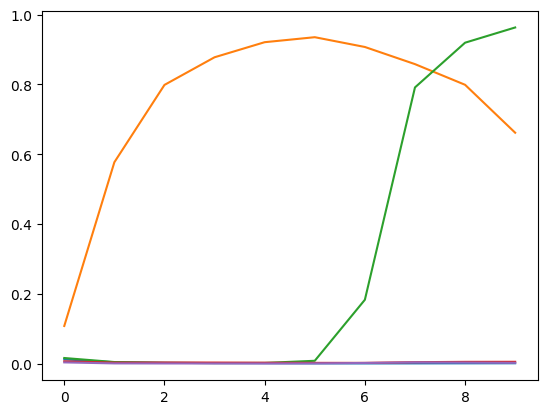

24 34
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[False False  True False False]


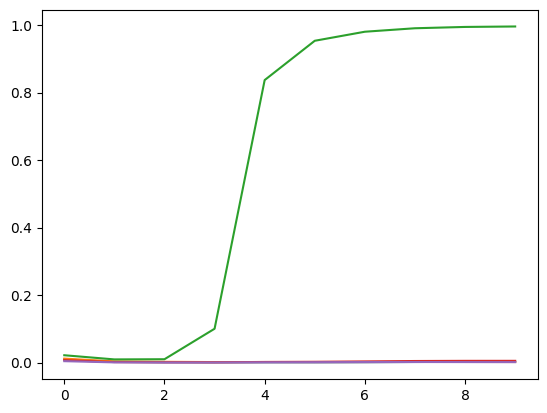

30 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[False False  True False False]


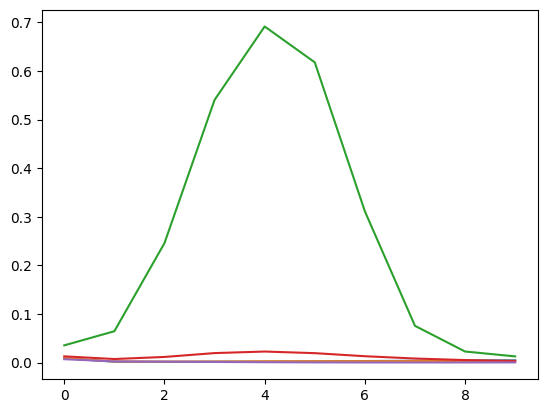

36 46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[False False False False  True]


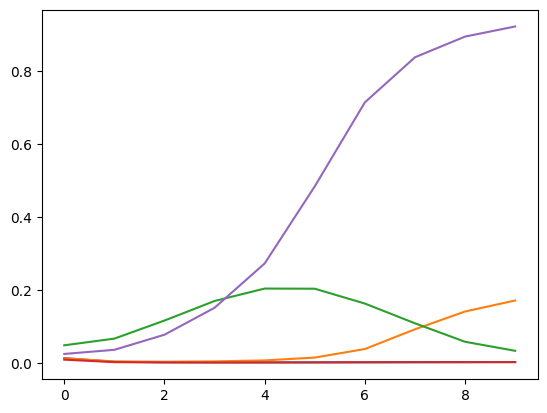

In [304]:
defects = np.array([False]*4 +[True])
input = createRow(60, defects)

single_sample = np.expand_dims(input, axis=0) 
output = model.predict(single_sample)[0]

window_size = 10
window_offset = 6

for i in range((length-window_offset)//window_offset):
    window = single_sample[:,i*window_offset:i*window_offset+window_size,:]
    print(i*window_offset,i*window_offset+window_size)
    output = model.predict(window)[0]
    print(np.max(output, axis=0)> 0.5)
    plt.plot(output)
    plt.show() 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
0 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
[ True False False False False]


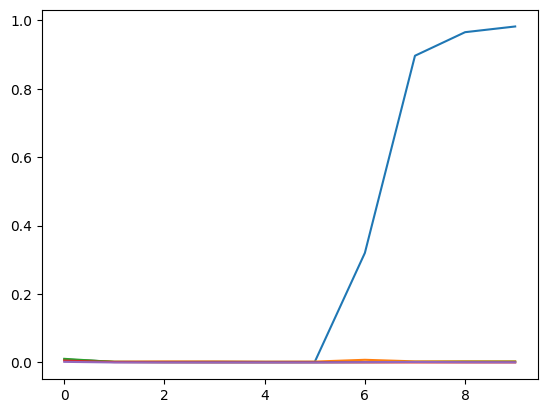

6 16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[ True False False False False]


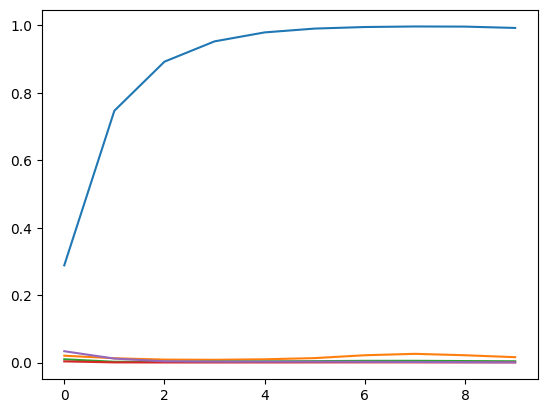

12 22
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[False  True  True False False]


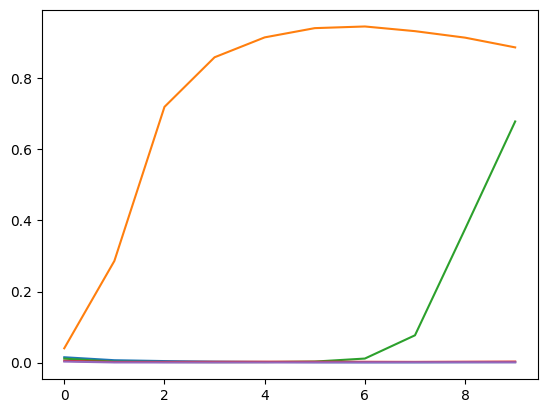

18 28
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[False  True  True False False]


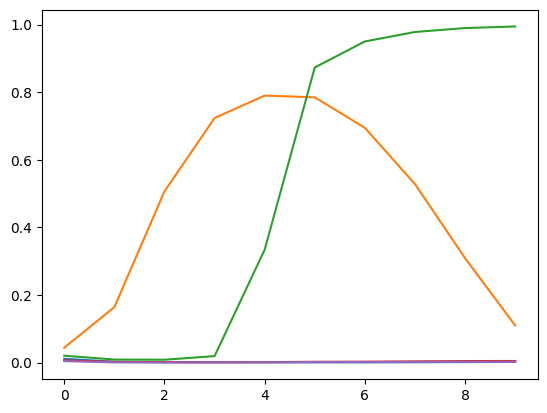

24 34
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[False False  True False False]


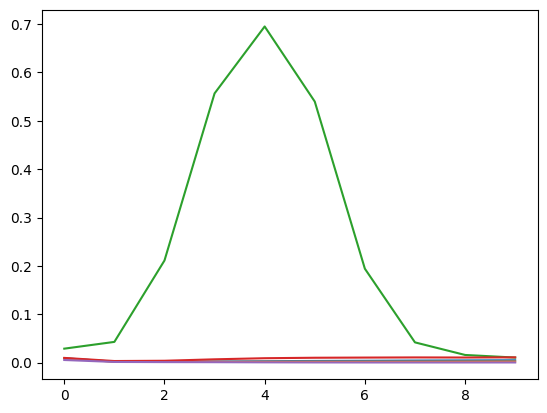

30 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[False False  True False False]


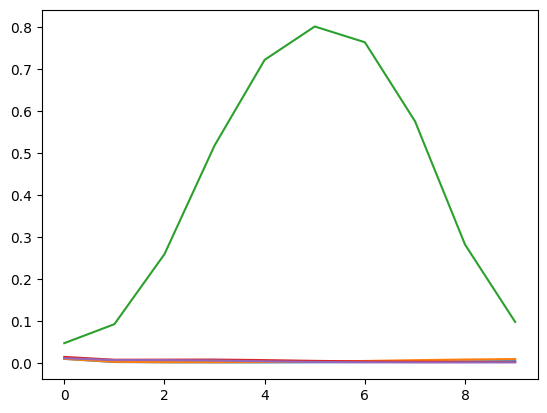

36 46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[False  True  True False  True]


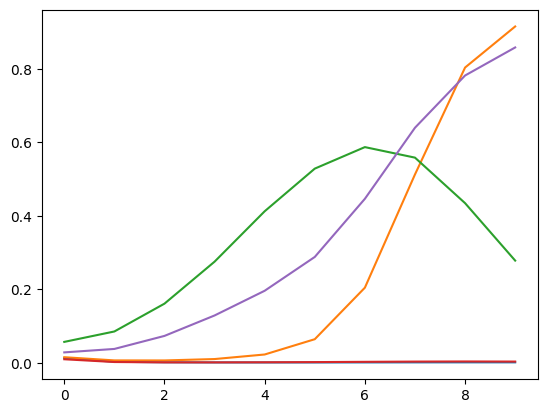

In [305]:
defects = np.array([True] +[False]*4)
input = createRow(60, defects)

single_sample = np.expand_dims(input, axis=0) 
output = model.predict(single_sample)[0]

window_size = 10
window_offset = 6

for i in range((length-window_offset)//window_offset):
    window = single_sample[:,i*window_offset:i*window_offset+window_size,:]
    print(i*window_offset,i*window_offset+window_size)
    output = model.predict(window)[0]
    print(np.max(output, axis=0)> 0.5)
    plt.plot(output)
    plt.show() 

This method has proven ineffective. Even when the defect is in the detected region, the sliding windows do not narrow it down enough and are not that precise. This implementation does not work well for defects that work over several steps. It works better on defects that exist only in 1 step, but the previous way of looking at the activation of the model is superior.